# Procrustes analysis of PFC tuning across development

Each task analysed independently (all its monkeys).

**3 tasks:** ODR 1.5s (8 monkeys), ODR 3.0s (4 monkeys), ODRd 20 conditions (4 monkeys)

**Pipeline:** Load data → PSTHs → tuning curves → age groups → PCA + Procrustes → statistics → temporal analysis

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys, os
sys.path.insert(0, '.')

from functions import (
    load_odr_data, load_odrd_data, split_odrd_by_distractor, extract_metadata,
    compute_single_trial_rates, compute_tuning_curves,
    build_representations, procrustes_distance_matrix,
    assign_age_groups, cross_monkey_analysis, cross_age_analysis,
    rates_to_psth, temporal_cross_monkey, temporal_cross_age, temporal_cross_age_by_pair,
    plot_cross_monkey, plot_distance_matrices, plot_cross_age,
    plot_temporal, plot_temporal_by_pair,
)

DATA_DIR     = '../data_raw'
N_AGE_GROUPS = 3
N_PCS        = 8
MIN_NEURONS  = N_PCS + 1
BIN_MS       = 50
WINDOW_MS    = 500
STEP_MS      = 50
N_BOOT       = 1000
CI           = 95
AGE_PAIRS    = [(0, 1), (1, 2), (0, 2)]

ODR15_EPOCHS = {'cue': (0, 500), 'delay': (500, 2000), 'response': (2000, 2500)}
ODR30_EPOCHS = {'cue': (0, 500), 'delay': (500, 3000), 'response': (3000, 3500)}
ODRD_EPOCHS  = {'cue': (0, 500), 'delay': (500, 1700), 'distractor': (1700, 2200), 'response': (3000, 3500)}

## 1. Load data

In [2]:
odr_data_all, ws_odr = load_odr_data(os.path.join(DATA_DIR, 'odr_data_both_sig_is_best_20240109.mat'))
ids_all, age_all, mature_all, delay_all = extract_metadata(ws_odr, odr_data_all.shape[0])

def _subset(mask):
    return odr_data_all[mask], ids_all[mask], age_all[mask], mature_all[mask]

odr15_data, odr15_ids, odr15_age, odr15_mat = _subset(delay_all == 1.5)
odr30_data, odr30_ids, odr30_age, odr30_mat = _subset(delay_all == 3.0)
odr15_abs_age = (odr15_age + odr15_mat) / 365.0 * 12.0
odr30_abs_age = (odr30_age + odr30_mat) / 365.0 * 12.0

odrd_raw, ws_odrd = load_odrd_data(os.path.join(DATA_DIR, 'odrd_data_sig_on_best_20231018.mat'))
odrd_ids, odrd_age, odrd_mat, _ = extract_metadata(ws_odrd, odrd_raw.shape[0])
odrd_abs_age = (odrd_age + odrd_mat) / 365.0 * 12.0
odrd_data = split_odrd_by_distractor(odrd_raw)

print(f'ODR 1.5s: {odr15_data.shape[0]} neurons, monkeys: {sorted(set(odr15_ids))}')
print(f'ODR 3.0s: {odr30_data.shape[0]} neurons, monkeys: {sorted(set(odr30_ids))}')
print(f'ODRd:     {odrd_data.shape[0]} neurons ({odrd_data.shape[1]} conds), monkeys: {sorted(set(odrd_ids))}')

ODR 1.5s: 1180 neurons, monkeys: ['OLI', 'PIC', 'QUA', 'ROS', 'SON', 'TRI', 'UNI', 'VIK']
ODR 3.0s: 922 neurons, monkeys: ['OLI', 'PIC', 'ROS', 'UNI']
ODRd:     1319 neurons (20 conds), monkeys: ['OLI', 'PIC', 'ROS', 'UNI']


## 2. Compute PSTHs and tuning curves

In [3]:
odr15_bins = np.arange(-1000, 2500 + BIN_MS, BIN_MS)
odr30_bins = np.arange(-1000, 3500 + BIN_MS, BIN_MS)
odrd_bins  = np.arange(-1000, 4000 + BIN_MS, BIN_MS)

odr15_bc = (odr15_bins[:-1] + odr15_bins[1:]) / 2.0
odr30_bc = (odr30_bins[:-1] + odr30_bins[1:]) / 2.0
odrd_bc  = (odrd_bins[:-1]  + odrd_bins[1:])  / 2.0

odr15_rates = compute_single_trial_rates(odr15_data, odr15_bins)
odr30_rates = compute_single_trial_rates(odr30_data, odr30_bins)
odrd_rates  = compute_single_trial_rates(odrd_data,  odrd_bins)

odr15_tuning, _ = compute_tuning_curves(odr15_rates, odr15_bc, ODR15_EPOCHS)
odr30_tuning, _ = compute_tuning_curves(odr30_rates, odr30_bc, ODR30_EPOCHS)
odrd_tuning,  _ = compute_tuning_curves(odrd_rates,  odrd_bc,  ODRD_EPOCHS)

odr15_flat = odr15_tuning.reshape(odr15_tuning.shape[0], -1)
odr30_flat = odr30_tuning.reshape(odr30_tuning.shape[0], -1)
odrd_flat  = odrd_tuning.reshape(odrd_tuning.shape[0], -1)

print(f'ODR 1.5s: {odr15_flat.shape},  ODR 3.0s: {odr30_flat.shape},  ODRd: {odrd_flat.shape}')

  neuron 0/1180
  neuron 500/1180
  neuron 1000/1180
  neuron 0/922
  neuron 500/922
  neuron 0/1319
  neuron 500/1319
  neuron 1000/1319
ODR 1.5s: (1180, 24),  ODR 3.0s: (922, 24),  ODRd: (1319, 80)


## 3. Age groups, PCA, Procrustes, and statistics

In [4]:
tasks = {
    'ODR 1.5s': dict(tuning=odr15_flat, ids=odr15_ids, abs_age=odr15_abs_age),
    'ODR 3.0s': dict(tuning=odr30_flat, ids=odr30_ids, abs_age=odr30_abs_age),
    'ODRd':     dict(tuning=odrd_flat,  ids=odrd_ids,  abs_age=odrd_abs_age),
}

results = {}
for task_name, T in tasks.items():
    ag = assign_age_groups(T['ids'], T['abs_age'], N_AGE_GROUPS)
    entries = build_representations(T['tuning'], T['ids'], ag,
                                    n_pcs=N_PCS, min_neurons=MIN_NEURONS, zscore=True)
    dist = procrustes_distance_matrix(entries)
    labels = [f"{e['monkey']}_G{e['group']}" for e in entries]

    cm = cross_monkey_analysis(entries, dist)
    ca = cross_age_analysis(entries, dist)

    results[task_name] = dict(
        entries=entries, dist=dist, labels=labels, age_group=ag,
        cross_monkey=cm, cross_age=ca,
    )
    print(f'{task_name}: {len(entries)} entries, '
          f'cross>within t={cm["t_stat"]:.2f} p={cm["p_val"]:.4f}, '
          f'identity>age t={ca["t_stat"]:.2f} p={ca["p_val"]:.4f}')

ODR 1.5s: 24 entries, cross>within t=5.21 p=0.0000, identity>age t=3.53 p=0.0007
ODR 3.0s: 12 entries, cross>within t=5.66 p=0.0000, identity>age t=2.81 p=0.0121
ODRd: 12 entries, cross>within t=11.39 p=0.0000, identity>age t=6.59 p=0.0000


## 4. Cross-monkey analysis

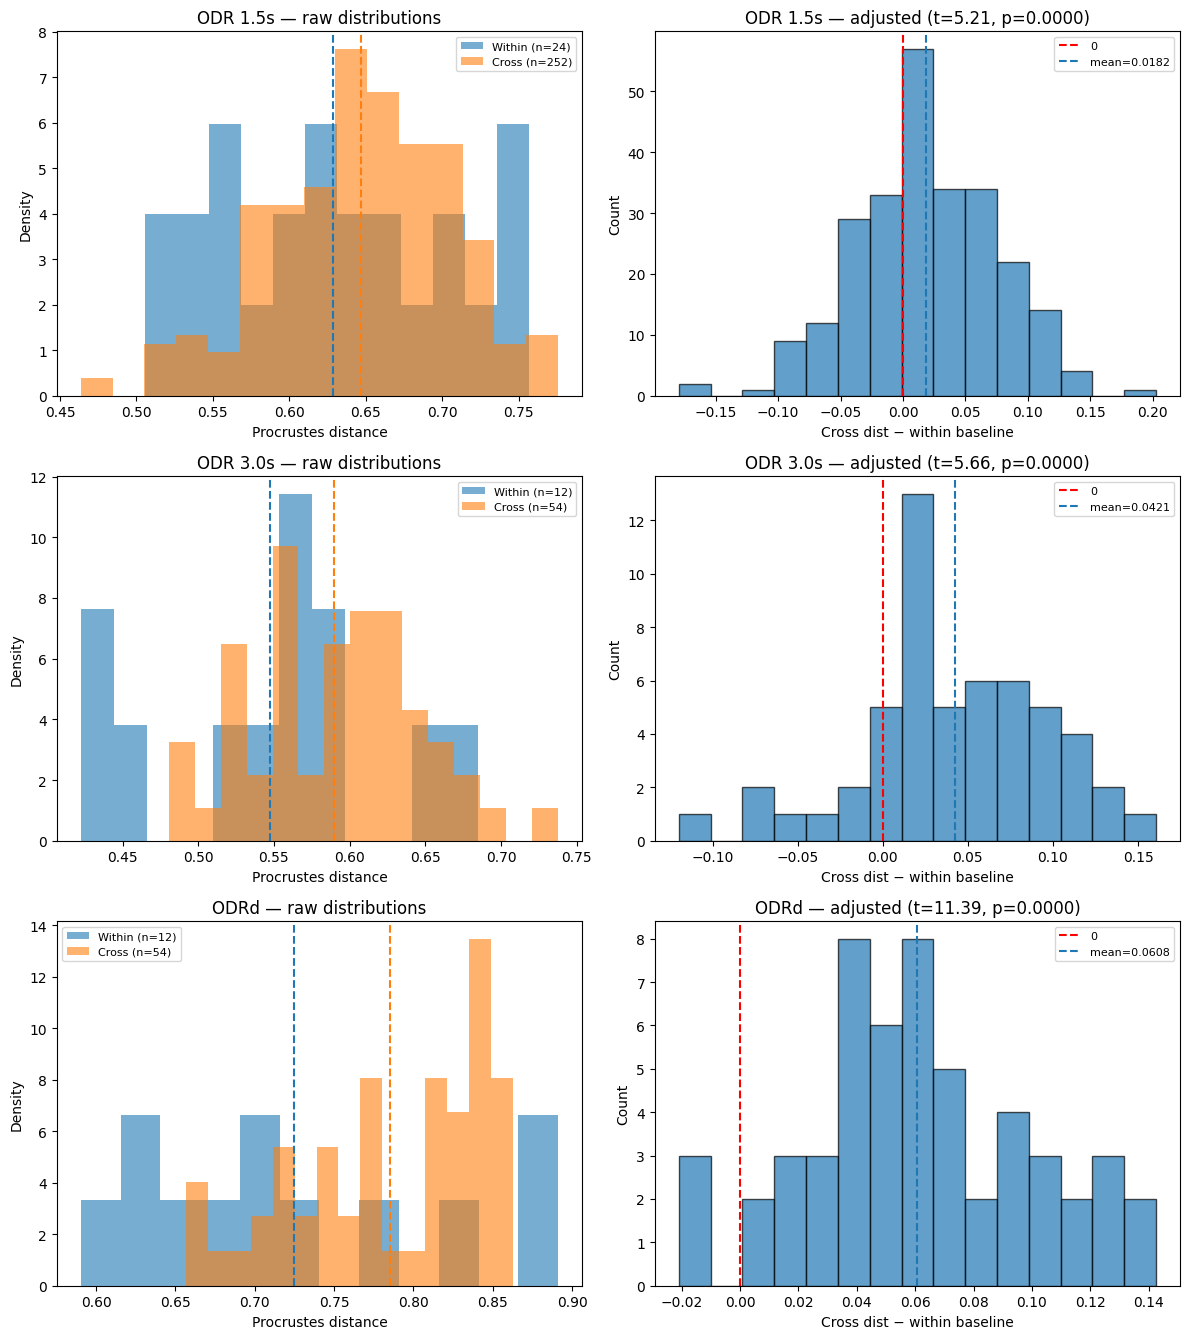

In [5]:
plot_cross_monkey(results)

## 5. Distance matrices

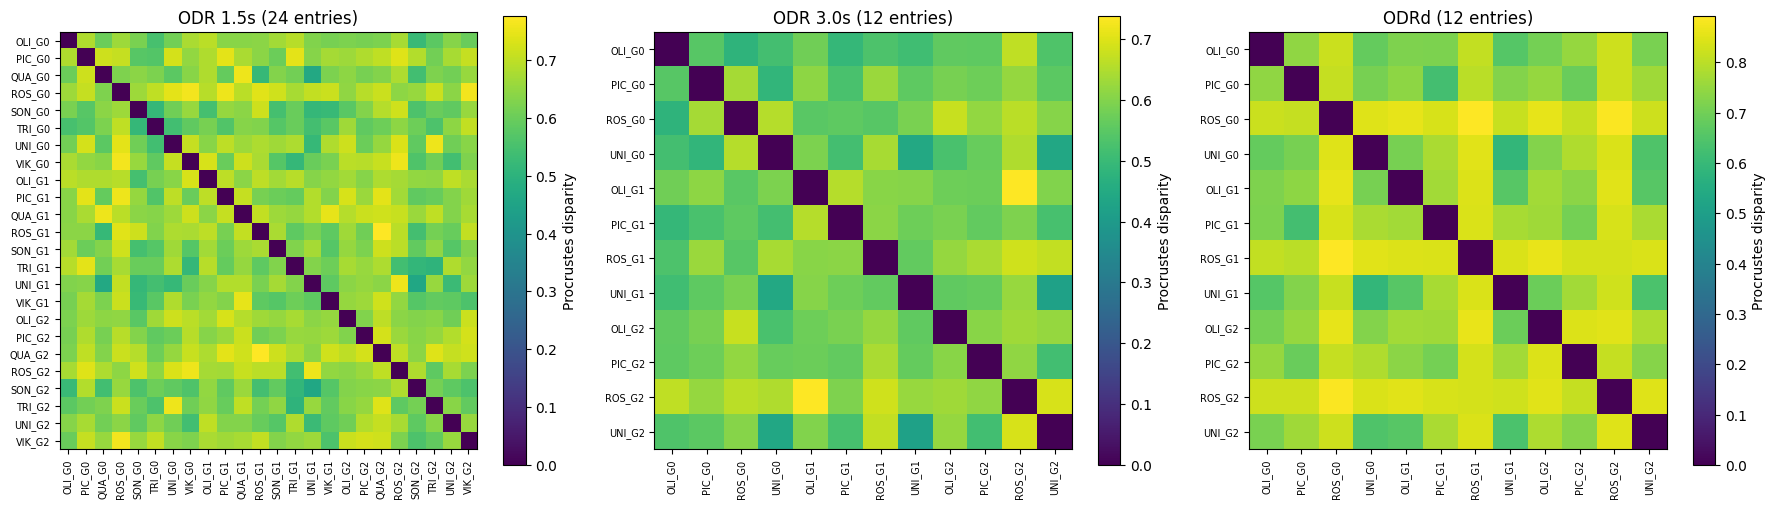

In [6]:
plot_distance_matrices(results)

## 6. Cross-age analysis

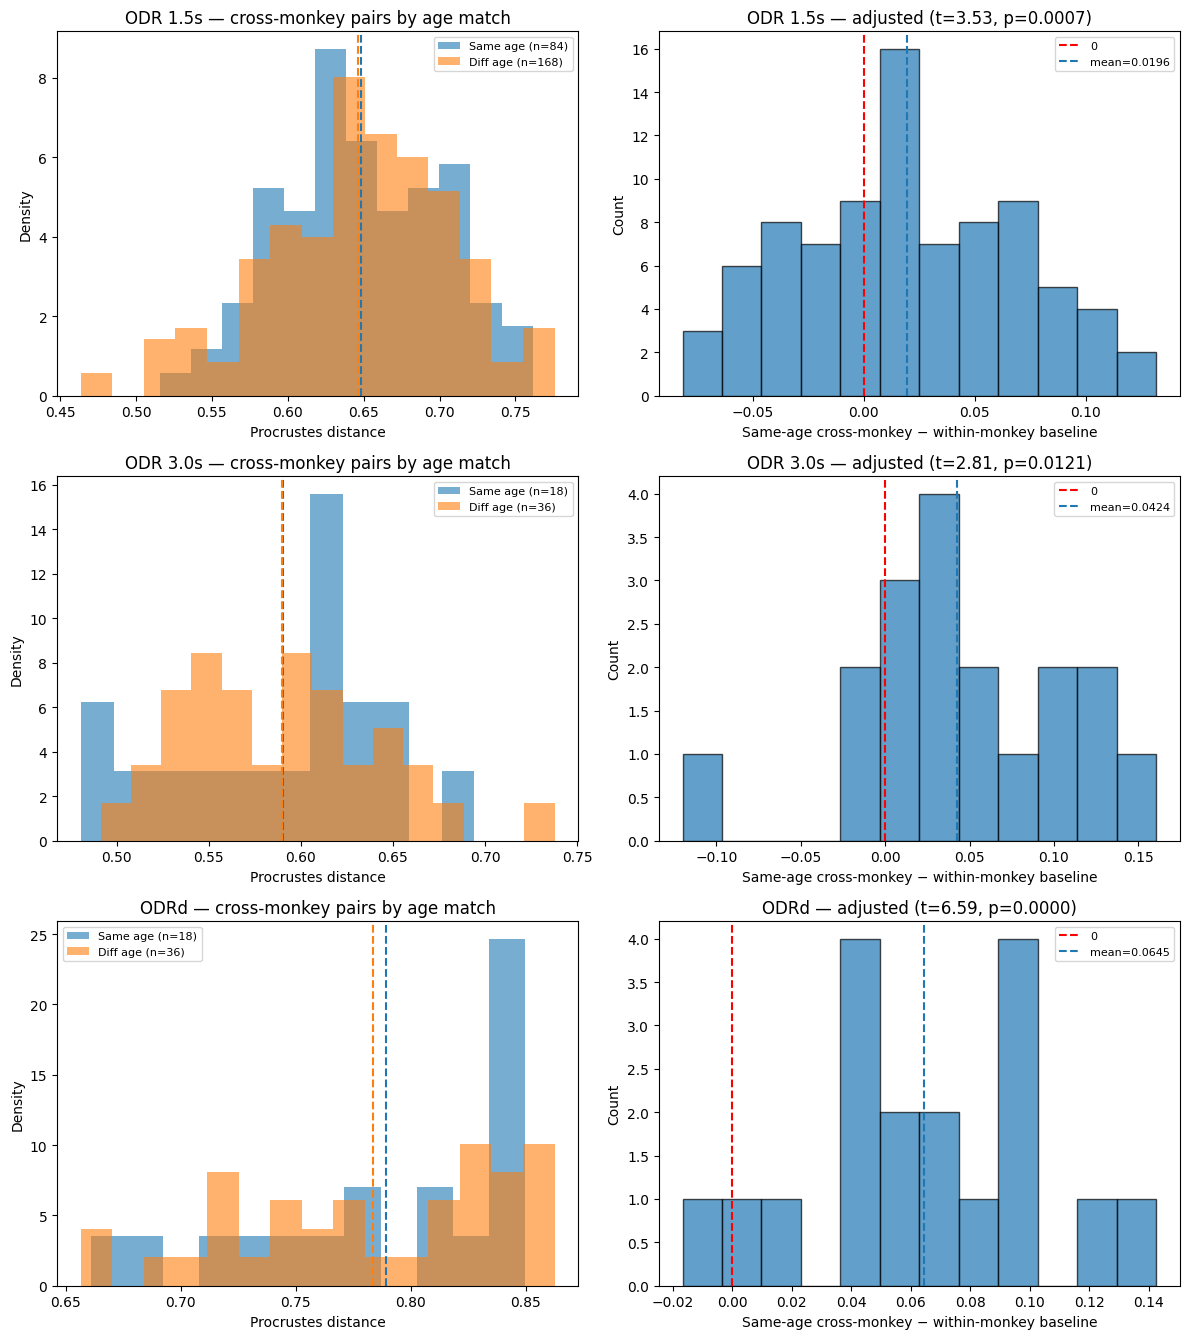

In [7]:
plot_cross_age(results)

## 7. Temporal cross-monkey distances

### 7.1 All monkeys

ODR 1.5s: 61 time points
ODR 3.0s: 81 time points
ODRd: 91 time points


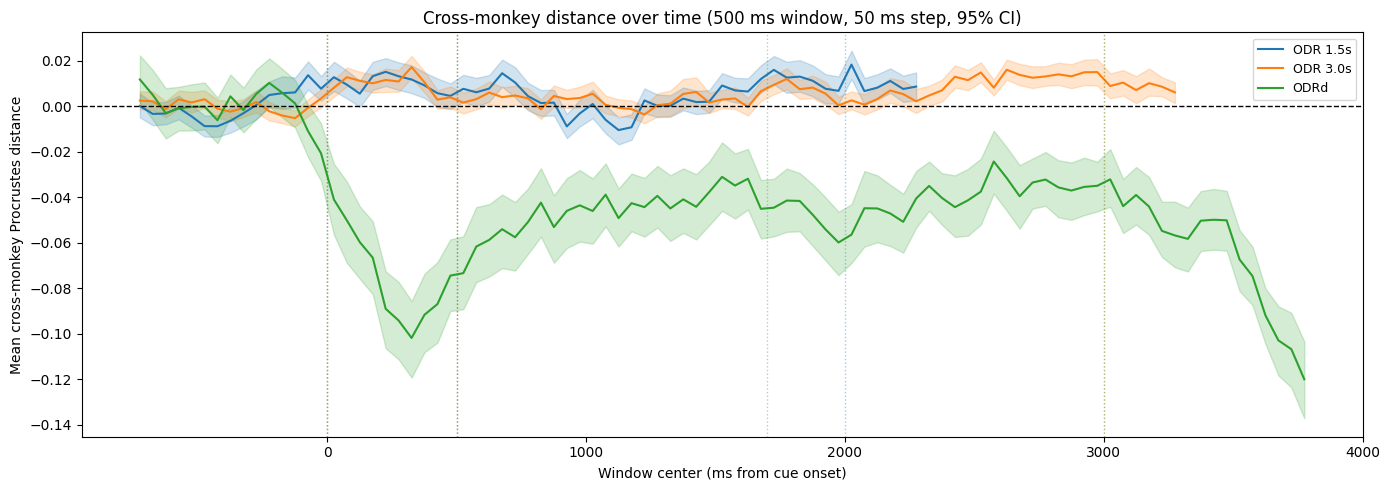

In [8]:
task_temporal = {
    'ODR 1.5s': (odr15_rates, odr15_bc, odr15_ids),
    'ODR 3.0s': (odr30_rates, odr30_bc, odr30_ids),
    'ODRd':     (odrd_rates,  odrd_bc,  odrd_ids),
}

# Compute PSTHs once (reused across temporal sections)
psths = {name: rates_to_psth(rates) for name, (rates, _, _) in task_temporal.items()}

temporal_monkey = {}
for name, (_, bc, ids) in task_temporal.items():
    t, boots = temporal_cross_monkey(psths[name], bc, ids, results[name]['age_group'],
                                     n_pcs=N_PCS, min_neurons=MIN_NEURONS,
                                     window_ms=WINDOW_MS, step_ms=STEP_MS, n_boot=N_BOOT)
    temporal_monkey[name] = dict(t=t, boots=boots)
    print(f'{name}: {len(t)} time points')

plot_temporal(temporal_monkey, ci=CI,
              ylabel='Mean cross-monkey Procrustes distance',
              title=f'Cross-monkey distance over time ({WINDOW_MS} ms window, {STEP_MS} ms step, {CI}% CI)')

### 7.2 Common monkeys only (OLI, PIC, ROS, UNI)

In [ ]:
# Monkeys present in all three tasks
common_monkeys = sorted(set(odr15_ids) & set(odr30_ids) & set(odrd_ids))
print(f'Common monkeys: {common_monkeys}')

temporal_monkey_common = {}
for name, (_, bc, ids) in task_temporal.items():
    mask = np.isin(ids, common_monkeys)
    psth_c = psths[name][mask]
    ids_c = ids[mask]
    ag_c = results[name]['age_group'][mask]

    t, boots = temporal_cross_monkey(psth_c, bc, ids_c, ag_c,
                                     n_pcs=N_PCS, min_neurons=MIN_NEURONS,
                                     window_ms=WINDOW_MS, step_ms=STEP_MS, n_boot=N_BOOT)
    temporal_monkey_common[name] = dict(t=t, boots=boots)
    print(f'{name}: {mask.sum()} neurons, {len(t)} time points')

plot_temporal(temporal_monkey_common, ci=CI,
              ylabel='Mean cross-monkey Procrustes distance',
              title=f'Cross-monkey distance (common monkeys) ({WINDOW_MS} ms window, {STEP_MS} ms step, {CI}% CI)')

## 8. Temporal cross-age distances

ODR 1.5s: 61 time points
ODR 3.0s: 81 time points
ODRd: 91 time points


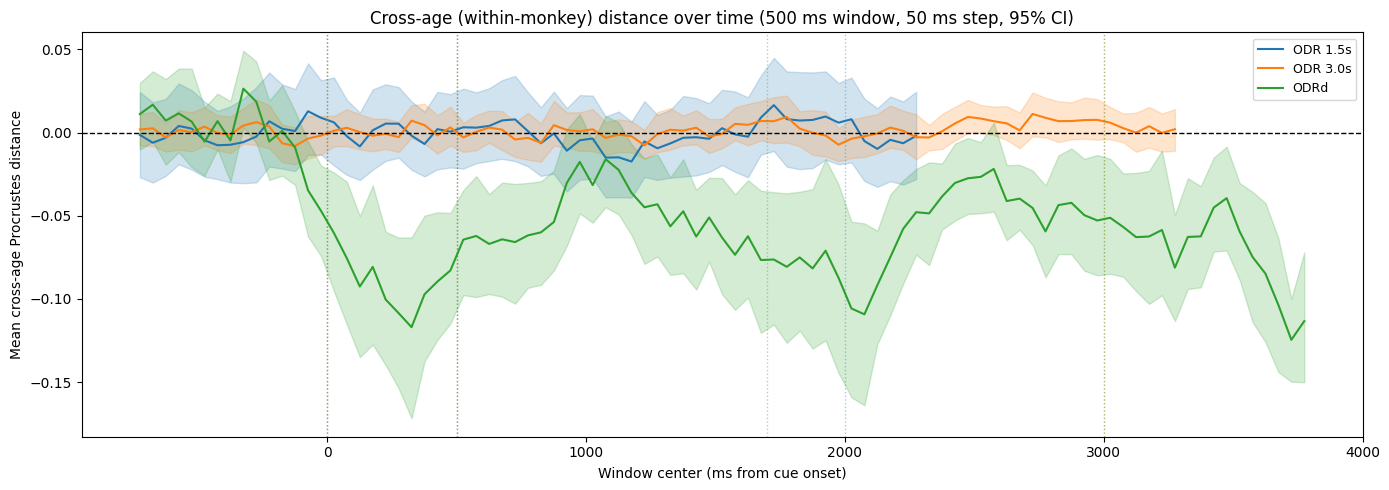

In [9]:
temporal_age = {}
for name, (_, bc, ids) in task_temporal.items():
    t, boots = temporal_cross_age(psths[name], bc, ids, results[name]['age_group'],
                                  n_pcs=N_PCS, min_neurons=MIN_NEURONS,
                                  window_ms=WINDOW_MS, step_ms=STEP_MS, n_boot=N_BOOT)
    temporal_age[name] = dict(t=t, boots=boots)
    print(f'{name}: {len(t)} time points')

plot_temporal(temporal_age, ci=CI,
              ylabel='Mean cross-age Procrustes distance',
              title=f'Cross-age (within-monkey) distance over time ({WINDOW_MS} ms window, {STEP_MS} ms step, {CI}% CI)')

## 9. Temporal cross-age by pair

ODR 1.5s: 61 time points
ODR 3.0s: 81 time points
ODRd: 91 time points


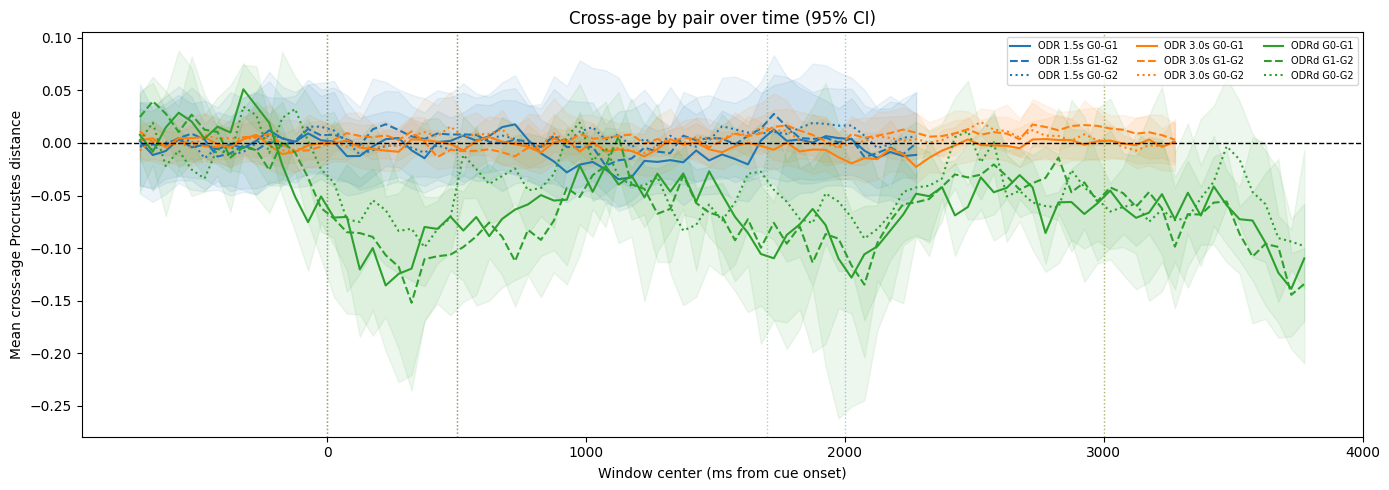

In [10]:
temporal_pairs = {}
for name, (_, bc, ids) in task_temporal.items():
    t, boots_by_pair = temporal_cross_age_by_pair(
        psths[name], bc, ids, results[name]['age_group'], AGE_PAIRS,
        n_pcs=N_PCS, min_neurons=MIN_NEURONS,
        window_ms=WINDOW_MS, step_ms=STEP_MS, n_boot=N_BOOT)
    temporal_pairs[name] = dict(t=t, boots_by_pair=boots_by_pair)
    print(f'{name}: {len(t)} time points')

plot_temporal_by_pair(temporal_pairs, ci=CI)

## 10. Bootstrap comparison of age pairs (ODRd)

In [11]:
from functions.plotting import _baseline_normalize

age_dist = {}
for task_name, TR in temporal_pairs.items():
    age_dist[task_name] = {}
    for pair, boots in TR['boots_by_pair'].items():
        boots_norm = _baseline_normalize(boots, TR['t'])
        age_dist[task_name][pair] = boots_norm[:, TR['t'] > 0].mean(1)

d_01 = age_dist['ODRd'][(0, 1)]
d_12 = age_dist['ODRd'][(1, 2)]
d_02 = age_dist['ODRd'][(0, 2)]

print(f'P(G0-G1 >= G1-G2): {1 - np.mean(d_01.mean() >= d_12)}')
print(f'P(G0-G1 >= G0-G2): {np.mean(d_01.mean() >= d_02)}')
print(f'P(G1-G2 >= G0-G2): {np.mean(d_12.mean() >= d_02)}')

P(G0-G1 >= G1-G2): 0.34299999999999997
P(G0-G1 >= G0-G2): 0.001
P(G1-G2 >= G0-G2): 0.0
